In [32]:
# faster RCNN related
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
import caffe

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import cv2
import json
import math
import random
import shutil
from util_fxns import *
from collections import Counter

%matplotlib inline

In [12]:
seed=42
random.seed(seed)

In [2]:
cfg.GPU_ID = 1
caffe.set_device(1)
caffe.set_mode_gpu()

In [3]:
# define directories
data_dir = "/home/ai2-c3p0/Documents/code/todd_working_directory/KaggleFisheries/data/"

In [4]:
CLASSES = ('__background__','fish')

NETS = {'vgg16': ('VGG16','vgg16_faster_rcnn_fishies_iter_10000.caffemodel')}

In [5]:
cfg.TEST.HAS_RPN = True  # Use RPN for proposals

prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16'][0],
                       'faster_rcnn_end2end_fishies_binary', 'test.prototxt')

faster_rcnn_dir = '/home/ai2-c3p0/Documents/code/todd_working_directory/KaggleFisheries/py-faster-rcnn/output/faster_rcnn_end2end/kaggle_fishies_train/'

caffemodel = os.path.join(faster_rcnn_dir,NETS['vgg16'][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))

In [6]:
net = caffe.Net(prototxt, caffemodel, caffe.TEST)
print 'Loaded network {:s}'.format(caffemodel)

Loaded network /home/ai2-c3p0/Documents/code/todd_working_directory/KaggleFisheries/py-faster-rcnn/output/faster_rcnn_end2end/kaggle_fishies_train/vgg16_faster_rcnn_fishies_iter_10000.caffemodel


In [7]:
def predict(image_path,classes=None,conf_thresh=.5,nms_thresh=0.01,net=None, visualize_detections=False,\
            fig_size=12, buff=10):
    """Detect object classes in an image using pre-computed object proposals
    Args:
        image_path (str) : image file path
        classes (list) : list of class labels
        conf_thresh (float) : number between 0 and 1 (probability threshold), which determines which bounding boxes
        to accept. Defaults to 0.5.
        nms_thresh (float) : non-maximum suppression threshold. Defaults to 0.01.
        net (caffe.Net) : pre-trained caffe model
        visualize_detections (bool) : optionally display images and predicted bounding boxes. Defaults to False.
        fig_size (int) : size of the display, if visualize_detections is True
        buff (int) : optional pixel buffer around the predicted bounding boxes
    
    Returns:
        image_path (str) OR pred_results (dict) : image file path if no bounding box predictions, else the bounding
        box predictions 
    """
    
    im = cv2.imread(image_path)
    image_name = image_path.split("/")[-1]
    img_shape = im.shape
    
    # Detect all object classes and regress object bounds
    scores, boxes = im_detect(net, im)
    #     print ('Detection took {:.3f}s for '
    #            '{:d} object proposals').format(timer.total_time, boxes.shape[0])
    
    no_detections = []
    # Visualize detections for each class
    for cls_ind, cls in enumerate(classes[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)] # bounding boxes
        cls_scores = scores[:, cls_ind] # probability scores
        dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, nms_thresh) # determine which boxes to keep based on the nms_thresh
        dets = dets[keep, :] # final detections
        
        inds = np.where(dets[:, -1] >= conf_thresh)[0]
        
        if visualize_detections and len(inds) != 0:
            vis_detections(im, cls, dets, conf_thresh, fig_size, buff)
        
        # will return image name if no detections
        if len(inds) == 0:
            return image_path
        else:
            pred_results = bbox_results(image_path, img_shape, cls, dets, inds, buff)
            return pred_results

In [9]:
def vis_detections(im, class_name, dets, conf_thresh, fig_size=12, buff=10):
    """Draw detected bounding boxes on a given image
    
    Args:
        im (numpy.array) : image pixel data
        class_name (str) : class label
        dets (numpy.array) : bounding box detections and metadata (e.g. probability)
        conf_thresh (float) : number between 0 and 1 (probability threshold), which determines which bounding boxes
        to accept. Defaults to 0.5.
        fig_size (int) : size of the display, if visualize_detections is True
        buff (int) : optional pixel buffer around the predicted bounding boxes 
    """

    im = im[:, :, (2, 1, 0)] # swapping color channels
    img_shape = im.shape
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        #adjust the bounding box according to the buffer
        bbox[0], bbox[1], bbox[2], bbox[3] = bbox[0]-buff,bbox[1]-buff, bbox[2]+buff, bbox[3]+buff
        bbox = check_bbox_in_image(bbox,img_shape)
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=2)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  conf_thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [8]:
def bbox_results(image_path, img_shape, class_name, dets, inds, buff=10):
    """Returns detected bounding boxes and associated metadata (e.g. probability, annotation count, etc.)
    
    Args:
        image_path (str) : image file path
        img_shape (tuple) : shape of the image (width, height, color channels)
        class_name (str) : class label
        dets (numpy.array) : bounding box detections and metadata (e.g. probability)
        inds (list) : list of indices of valid detections
        buff (int) : optional pixel buffer around the predicted bounding boxes
        
    Returns:
        annotations_pred (dict) : annotation predictions and associated metadata
    """
    
    image_file_name = image_path.split("/")[-1]
    class_label = image_path.split("/")[-2] # ground truth class label
    annotations_pred = {}
    annotations_pred['full_path'] = image_path
    annotations_pred['faster_rcnn_class'] = class_name
    annotations_pred['ground_truth_label'] = class_label
    annotations_pred['annotation_results'] = []
    
    annotation_count = 0
    for i in inds:
        bbox = dets[i, :4] # bbox
        bbox[0], bbox[1], bbox[2], bbox[3] = bbox[0]-buff,bbox[1]-buff, bbox[2]+buff, bbox[3]+buff
        bbox = check_bbox_in_image(bbox,img_shape)
        score = dets[i, -1] # probability
        annotations_pred['annotation_results'].append({"bbox":bbox.tolist(), "probability":score, 
                                                       "annotation_count":annotation_count})
        annotation_count += 1
        
    return annotations_pred

In [13]:
inference_images = []
competition_dir = "/home/ai2-c3p0/Documents/code/todd_working_directory/KaggleFisheries/data/test_stg1/"
for image in os.listdir(competition_dir):
    inference_images.append(competition_dir+image)
random.shuffle(inference_images)

Image name: img_05038.jpg


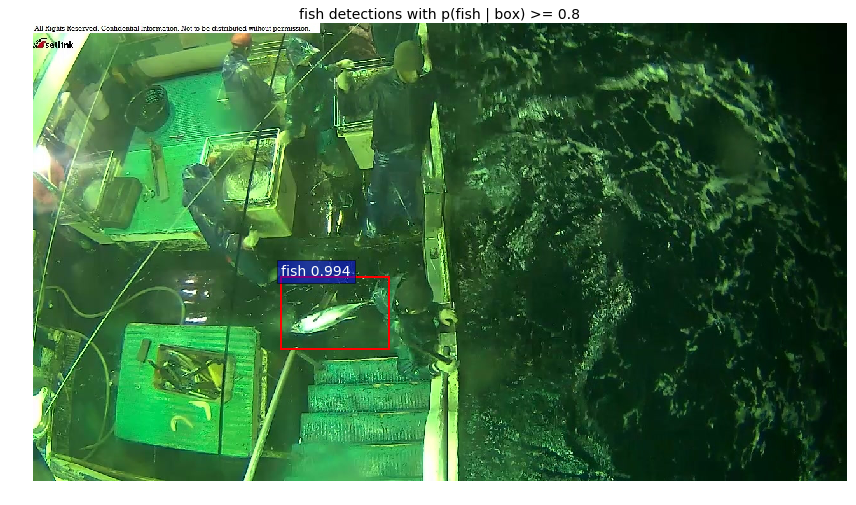

Image name: img_01552.jpg


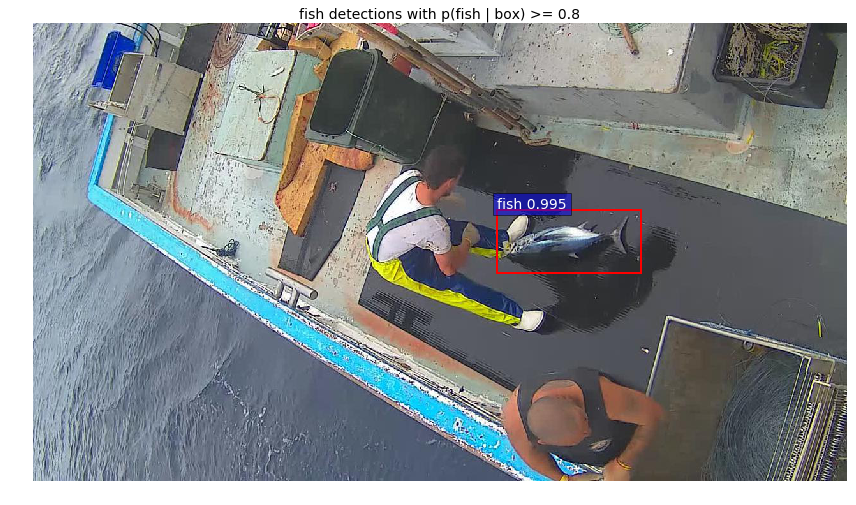

Image name: img_04642.jpg
Image name: img_02307.jpg


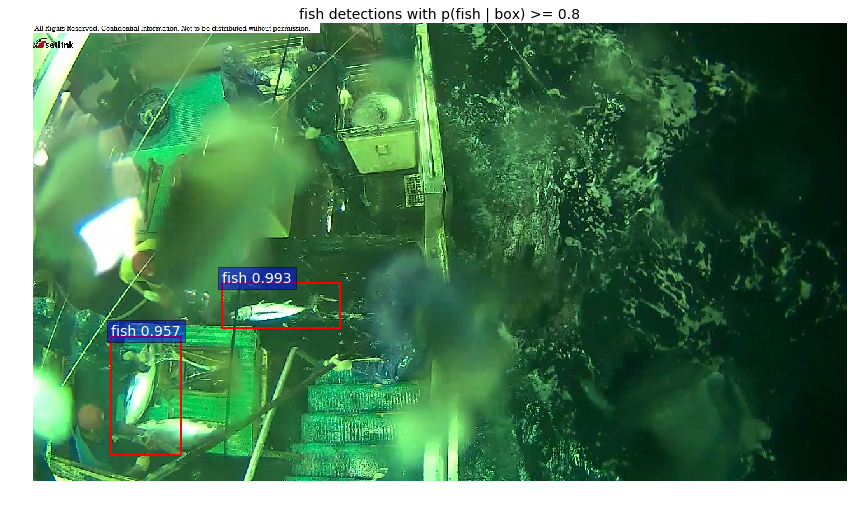

Image name: img_07799.jpg


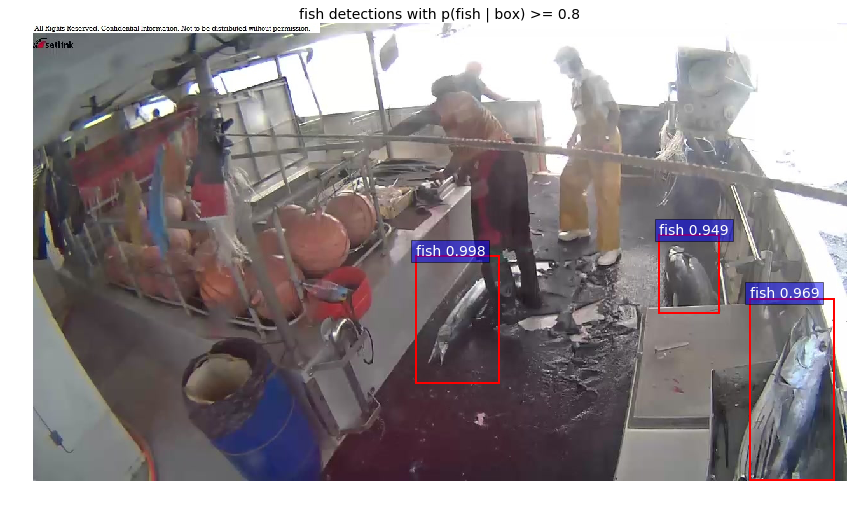

In [14]:
annotations_pred = {}
no_fish = []

for img in inference_images[:5]:
    img_name = img.split("/")[-1]
    print "Image name: {}".format(img_name)
    return_val = predict(img, classes=CLASSES, conf_thresh=.8, net=net, visualize_detections=True,buff=10,vis_ground_truth=False,annotations=None)
    if type(return_val) == str:
        no_fish.append(return_val)
    else:
        annotations_pred[img_name] = return_val
    plt.show()

In [15]:
# no visualization, predict results for all test images
annotations_pred = {}
no_fish = []

for img in inference_images:
    img_name = img.split("/")[-1]
    return_val = predict(img, classes=CLASSES, conf_thresh=.8, net=net, visualize_detections=False,buff=10,vis_ground_truth=False,annotations=None)
    if type(return_val) == str:
        no_fish.append(return_val)
    else:
        annotations_pred[img_name] = return_val
    plt.show()

In [29]:
# save the no_fish images for retrieval later
no_fish_file = data_dir + "no_fish.txt"
try:
    os.remove(no_fish_file)
except:
    "Nothing to delete"
with open(no_fish_file,'w') as f:
    for pic in no_fish:
        f.write(pic+"\n")

In [20]:
def extract_bboxes(image_name, predicted_annotations):
    """
    Args:
        image_name (str) : image name
        predicted_annotations (dict) : the predicted annotations from faster rcnn 
    
    Returns:
        results (list) : list containing image_name, bbox_counter, class, probability, bbox, filepath
    """    
    filepath = predicted_annotations[image_name]["full_path"]
    class_label = predicted_annotations[image_name]["faster_rcnn_class"]
    results = []
    for bbox_pred in predicted_annotations[image_name]["annotation_results"]:
        results.append([image_name, bbox_pred["annotation_count"], class_label,bbox_pred["probability"],bbox_pred["bbox"],filepath])
    
    return results

In [25]:
results_cols = ["image_name", "bbox_counter", "faster_rcnn_class", "probability","bbox","filepath"]
rename_dict = {}
for i, col_name in enumerate(results_cols):
    rename_dict[i] = col_name

In [26]:
results_df = pd.DataFrame()
for photo in annotations_pred:
    results_df = results_df.append(extract_bboxes(photo,annotations_pred))

In [27]:
results_df = results_df.rename_axis(rename_dict,1)
results_df.head()

,image_name,bbox_counter,faster_rcnn_class,probability,bbox,filepath
0,img_05328.jpg,0,fish,0.998492,"[363.019744873, 171.661193848, 625.084533691, ...",/home/ai2-c3p0/Documents/code/todd_working_dir...
0,img_04382.jpg,0,fish,0.995947,"[396.656463623, 416.485626221, 536.427429199, ...",/home/ai2-c3p0/Documents/code/todd_working_dir...
0,img_00071.jpg,0,fish,0.996396,"[89.5418243408, 403.282287598, 178.372787476, ...",/home/ai2-c3p0/Documents/code/todd_working_dir...
1,img_00071.jpg,1,fish,0.995986,"[795.620788574, 251.980102539, 1079.65917969, ...",/home/ai2-c3p0/Documents/code/todd_working_dir...
2,img_00071.jpg,2,fish,0.855314,"[694.015930176, 547.254882812, 1052.58435059, ...",/home/ai2-c3p0/Documents/code/todd_working_dir...


In [28]:
results_df.groupby(by="faster_rcnn_class").mean().reset_index()

,faster_rcnn_class,bbox_counter,probability
0,fish,0.410686,0.982341


### Crop predictions for classifier inference

In [34]:
def crop_im(image_path=None,bbox=None,bbox_counter=None,faster_rcnn_class=None,save_dir=None):
    """Crop image for all instances of a class in an image and save the results to 
    a folder for that class
    
    Args:
        image_path (str) : path where the image is saved
        bbox (list) : bounding box for the crop
        faster_rcnn_class : faster rcnn class label
        save_dir (str) : path to the directory to save crops
    """
    im = cv2.imread(image_path)
    pic = image_path.split("/")[-1]
    pic_name = pic.split(".")[0]
    img_shape = im.shape
    
    y = int(math.ceil(bbox[1]))
    x = int(math.ceil(bbox[0]))
    h = int(math.ceil(bbox[3] - bbox[1]))
    w = int(math.ceil(bbox[2] - bbox[0]))

    im_crop = im[y:y+h,x:x+w]
    # rotate images if they are taller than they are wide
    # reorientating images should be helpful to the classifier
    if h / float(w) > 1:
        im_crop = rotate_bound(im_crop,90)

    cv2.imwrite(save_dir+"{0}/{1}_{2}.jpg".format(ground_truth_class,\
                                                  pic_name,bbox_counter),im_crop)

In [35]:
inference_crops_dir = data_dir + "predicted_inference_crops/"
try:
    shutil.rmtree(inference_crops_dir)
except:
    "Nothing to delete"

os.mkdir(inference_crops_dir)
for class_label in CLASSES[1:]: # skip the background class
    os.mkdir(inference_crops_dir+class_label)

In [36]:
for _,row in results_df.iterrows():
    crop_im(row["filepath"],row["bbox"],row["bbox_counter"],row["faster_rcnn_class"],inference_crops_dir)

In [38]:
def count_dir(directory):
    count=0
    for folder in os.listdir(directory):
        for _ in os.listdir(directory+folder):
            count+=1
    
    return count

In [41]:
assert len(results_df) == count_dir(inference_crops_dir)